In [1]:
##################################
#                                #
# regression_TOH.ipynb           #
# Created 2023-05-20             #
# Akhil Garg, akhil@akhilgarg.ca #
#                                #
##################################

import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import pickle
import os
import itertools

from sklearn import preprocessing
from sklearn import pipeline
from sklearn import linear_model
from sklearn import metrics

import matplotlib.pyplot as plt

#pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
data = pd.read_excel('2024-05-20 AMR_imputation_TOH.xlsx')
original_columns = list(data)
data

,AgeCat,Sex,CULTURE_DESCRIPTION,FINAL,ADMIT_SVC,Acquisition,RecentHospitalization,ClinicalESBL,PriorAMG,PriorCarbapenem,...,Levofloxacin_PGNO_imp,Moxifloxacin_PGNO_imp,Daptomycin_PGNO_imp,Vancomycin_PGNO_imp,Linezolid_PGNO_imp,Amikacin_PGNO_imp,Gentamicin_PGNO_imp,Clindamycin_PGNO_imp,Doxycycline_PGNO_imp,Erythromycin_PGNO_imp
0,85-90,F,URINE QUANTITATIVE CULTURE,Citrobacter freundii complex,Surgical,Community,0,0,0,0,...,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable
1,85-90,F,ROUTINE CULTURE (AEROBIC SWAB),Pseudomonas aeruginosa,Medical,Community,1,0,0,0,...,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable
2,<40,F,URINE QUANTITATIVE CULTURE,Escherichia coli,Surgical,Community,0,0,0,0,...,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable
3,>90,M,URINE QUANTITATIVE CULTURE,Klebsiella pneumoniae,Medical,Community,1,0,0,0,...,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable
4,65-70,M,BLOOD CULTURE,Klebsiella (Enterobacter) aerogenes,Surgical,Community,0,0,0,0,...,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1563,70-75,M,BLOOD CULTURE,Klebsiella pneumoniae,Medical,Community,0,0,0,0,...,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable
1564,70-75,M,BLOOD CULTURE,Klebsiella pneumoniae,Medical,Community,0,0,0,0,...,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable
1565,55-60,M,AEROBIC/ANAEROBIC CULTURE,Enterobacter cloacae complex,Surgical,Hospital,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1566,70-75,M,URINE QUANTITATIVE CULTURE,Proteus mirabilis,Medical,Community,0,0,0,0,...,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable


In [3]:
list(data)

['AgeCat',
 'Sex',
 'CULTURE_DESCRIPTION',
 'FINAL',
 'ADMIT_SVC',
 'Acquisition',
 'RecentHospitalization',
 'ClinicalESBL',
 'PriorAMG',
 'PriorCarbapenem',
 'PriorCephalosporin',
 'PriorFQ',
 'PriorPenicillin',
 'PriorOtherAbx',
 'AMIKACIN_FINAL',
 'AMOXICILLIN/CLAVULANIC ACID_FINAL',
 'AMPICILLIN_FINAL',
 'CEFAZOLIN_FINAL',
 'CEFIXIME_FINAL',
 'CEFOTAXIME_FINAL',
 'CEFTAZIDIME_FINAL',
 'CEFTOLOZANE / TAZOBACTAM_FINAL',
 'CEFTRIAXONE_FINAL',
 'CIPROFLOXACIN_FINAL',
 'ERTAPENEM_FINAL',
 'FOSFOMYCIN_FINAL',
 'GENTAMICIN_FINAL',
 'LEVOFLOXACIN_FINAL',
 'MOXIFLOXACIN_FINAL',
 'MEROPENEM_FINAL',
 'NITROFURANTOIN_FINAL',
 'PENICILLIN_FINAL',
 'PIPERACILLIN / TAZOBACTAM_FINAL',
 'TRIMETHOPRIM/SULFA_FINAL',
 'TETRACYCLINE_FINAL',
 'TOBRAMYCIN_FINAL',
 'VANCOMYCIN_FINAL',
 'PriorGNOrg',
 'AMIKACIN_PGNO',
 'AMOXICILLIN/CLAVULANIC ACID_PGNO',
 'AMPICILLIN_PGNO',
 'CEFAZOLIN_PGNO',
 'CEFTAZIDIME_PGNO',
 'CEFTRIAXONE_PGNO',
 'CIPROFLOXACIN_PGNO',
 'ERTAPENEM_PGNO',
 'GENTAMICIN_PGNO',
 'LEVOFLOX

In [4]:
# List of output antibiotics
output_antibiotics = ['Penicillin_FINAL_imp','Amoxiclav_FINAL_imp','Ampicillin_FINAL_imp','Cloxacillin_FINAL_imp','Piptaz_FINAL_imp','Cefazolin_FINAL_imp','Ceftriaxone_FINAL_imp','Ceftazidime_FINAL_imp','Ertapenem_FINAL_imp','Meropenem_FINAL_imp','Ciprofloxacin_FINAL_imp','Levofloxacin_FINAL_imp','Moxifloxacin_FINAL_imp','Daptomycin_FINAL_imp','Vancomycin_FINAL_imp','Linezolid_FINAL_imp','Amikacin_FINAL_imp','Tobramycin_FINAL_imp','Gentamicin_FINAL_imp','Clindamycin_FINAL_imp','Doxycycline_FINAL_imp','Erythromycin_FINAL_imp','TMPSMX_FINAL_imp']

# Missingness susceptibilities for each antibiotic
print('Missingness')
for abx in output_antibiotics:
    missingness = data[data[abx]=='no_data'].shape[0] / data.shape[0]
    print('{:<15} {:>6.2f}%'.format(abx.split('_')[0],missingness*100))
    
# Piperacillin-tazobactam or tobramycin missingness
print('{:<15} {:>6.2f}%'.format('Piptaz or tobra',
      data[(data['Piptaz_FINAL_imp']=='no_data')|(data['Tobramycin_FINAL_imp']=='no_data')].shape[0]/data.shape[0]*100))

Missingness
Penicillin        1.47%
Amoxiclav        10.52%
Ampicillin        7.78%
Cloxacillin       6.57%
Piptaz           13.46%
Cefazolin         9.69%
Ceftriaxone      10.91%
Ceftazidime      26.98%
Ertapenem        64.16%
Meropenem        11.73%
Ciprofloxacin     2.10%
Levofloxacin     13.33%
Moxifloxacin      4.72%
Daptomycin        1.47%
Vancomycin      100.00%
Linezolid         1.47%
Amikacin         91.39%
Tobramycin        2.81%
Gentamicin        1.15%
Clindamycin       4.02%
Doxycycline      83.67%
Erythromycin     57.53%
TMPSMX            3.32%
Piptaz or tobra  15.31%


## Preprocessing

In [5]:
# Add a column for hospital site 
data['hosp_Sunnybrook'] = 0
data['hosp_TOH'] = 1
data['hosp_Trillium'] = 0

In [6]:
# Change missing data in the final output imputation to be resistant
data[output_antibiotics] = data[output_antibiotics].replace('no_data','RESISTANT')

# Convert susceptible/intermediate/resistant to numerical categorical values
data = data.replace({'SUSCEPTIBLE':0,'INTERMEDIATE':1,'RESISTANT':1})

# Convert age to a continuous variable
age_categories = {'<40'  :30, 
                  '40-45':42.5,
                  '45-50':47.5,
                  '50-55':52.5,
                  '55-60':57.5,
                  '60-65':62.5,
                  '65-70':67.5,
                  '70-75':72.5,
                  '75-80':77.5,
                  '80-85':82.5,
                  '85-90':87.5,
                  '>90'  :95
                 }
data['Age'] = data['AgeCat'].replace(age_categories).infer_objects()

# Rename acquisition locations to match future code
data['Acquisition'] = data['Acquisition'].replace({'Community':'community','Hospital':'ward'})

# Rename admitting service to match future code
data['ADMIT_SVC'] = data['ADMIT_SVC'].replace({'Medical':'medical','Surgical':'surgical'})

# One hot encode categories
one_hot_data = pd.get_dummies(data, columns=['Sex','Acquisition','ADMIT_SVC'],
                                        prefix= ['sex','acquisition','adm_service'])
one_hot_data

C:\Users\notqu\AppData\Local\Temp\ipykernel_17804\2918569808.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace({'SUSCEPTIBLE':0,'INTERMEDIATE':1,'RESISTANT':1})
C:\Users\notqu\AppData\Local\Temp\ipykernel_17804\2918569808.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Age'] = data['AgeCat'].replace(age_categories).infer_objects()


,AgeCat,CULTURE_DESCRIPTION,FINAL,RecentHospitalization,ClinicalESBL,PriorAMG,PriorCarbapenem,PriorCephalosporin,PriorFQ,PriorPenicillin,...,hosp_TOH,hosp_Trillium,Age,sex_F,sex_M,acquisition_ICU,acquisition_community,acquisition_ward,adm_service_medical,adm_service_surgical
0,85-90,URINE QUANTITATIVE CULTURE,Citrobacter freundii complex,0,0,0,0,0,0,0,...,1,0,87.50,True,False,False,True,False,False,True
1,85-90,ROUTINE CULTURE (AEROBIC SWAB),Pseudomonas aeruginosa,1,0,0,0,0,0,0,...,1,0,87.50,True,False,False,True,False,True,False
2,<40,URINE QUANTITATIVE CULTURE,Escherichia coli,0,0,0,0,0,0,0,...,1,0,30.00,True,False,False,True,False,False,True
3,>90,URINE QUANTITATIVE CULTURE,Klebsiella pneumoniae,1,0,0,0,0,0,0,...,1,0,95.00,False,True,False,True,False,True,False
4,65-70,BLOOD CULTURE,Klebsiella (Enterobacter) aerogenes,0,0,0,0,0,0,0,...,1,0,67.50,False,True,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1563,70-75,BLOOD CULTURE,Klebsiella pneumoniae,0,0,0,0,0,0,0,...,1,0,72.50,False,True,False,True,False,True,False
1564,70-75,BLOOD CULTURE,Klebsiella pneumoniae,0,0,0,0,0,0,0,...,1,0,72.50,False,True,False,True,False,True,False
1565,55-60,AEROBIC/ANAEROBIC CULTURE,Enterobacter cloacae complex,1,0,0,0,0,0,1,...,1,0,57.50,False,True,False,False,True,False,True
1566,70-75,URINE QUANTITATIVE CULTURE,Proteus mirabilis,0,0,0,0,0,0,0,...,1,0,72.50,False,True,False,True,False,True,False


### Encode prior antibiotic exposure

In [7]:
# Create a column of prior exposure to either penicillins or aminoglycosides
conditions = [((one_hot_data['PriorPenicillin']==0) & (one_hot_data['PriorAMG']==0)),
              ((one_hot_data['PriorPenicillin']==1) | (one_hot_data['PriorAMG']==1))]
# default -1 value should not occur, and is an error-checking mechanism
one_hot_data['PriorPenicillin_or_AMG'] = np.select(conditions, [0,1], default=-1)

# Create new categories of "prior non-[antibiotic class]"
one_hot_data['PriorNonCephalosporin'] = one_hot_data[['PriorAMG','PriorCarbapenem','PriorFQ','PriorOtherAbx','PriorPenicillin']].any(axis='columns')
one_hot_data['PriorNonCarbapenem'] = one_hot_data[['PriorAMG','PriorCephalosporin','PriorFQ','PriorOtherAbx','PriorPenicillin']].any(axis='columns')
one_hot_data['PriorNonPenicillin'] = one_hot_data[['PriorAMG','PriorCephalosporin','PriorFQ','PriorOtherAbx','PriorCarbapenem']].any(axis='columns')
one_hot_data['PriorNonFQ'] = one_hot_data[['PriorAMG','PriorCephalosporin','PriorPenicillin','PriorOtherAbx','PriorCarbapenem']].any(axis='columns')
one_hot_data['PriorNonAMG'] = one_hot_data[['PriorFQ','PriorCephalosporin','PriorPenicillin','PriorOtherAbx','PriorCarbapenem']].any(axis='columns')
one_hot_data['PriorNonOtherAbx'] = one_hot_data[['PriorFQ','PriorAMG','PriorCephalosporin','PriorPenicillin','PriorCarbapenem']].any(axis='columns')

one_hot_data['PriorNonPenicillin_or_AMG'] = one_hot_data[['PriorFQ','PriorCephalosporin','PriorCarbapenem']].any(axis='columns')

one_hot_data

,AgeCat,CULTURE_DESCRIPTION,FINAL,RecentHospitalization,ClinicalESBL,PriorAMG,PriorCarbapenem,PriorCephalosporin,PriorFQ,PriorPenicillin,...,adm_service_medical,adm_service_surgical,PriorPenicillin_or_AMG,PriorNonCephalosporin,PriorNonCarbapenem,PriorNonPenicillin,PriorNonFQ,PriorNonAMG,PriorNonOtherAbx,PriorNonPenicillin_or_AMG
0,85-90,URINE QUANTITATIVE CULTURE,Citrobacter freundii complex,0,0,0,0,0,0,0,...,False,True,0,False,False,False,False,False,False,False
1,85-90,ROUTINE CULTURE (AEROBIC SWAB),Pseudomonas aeruginosa,1,0,0,0,0,0,0,...,True,False,0,False,False,False,False,False,False,False
2,<40,URINE QUANTITATIVE CULTURE,Escherichia coli,0,0,0,0,0,0,0,...,False,True,0,False,False,False,False,False,False,False
3,>90,URINE QUANTITATIVE CULTURE,Klebsiella pneumoniae,1,0,0,0,0,0,0,...,True,False,0,False,False,False,False,False,False,False
4,65-70,BLOOD CULTURE,Klebsiella (Enterobacter) aerogenes,0,0,0,0,0,0,0,...,False,True,0,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1563,70-75,BLOOD CULTURE,Klebsiella pneumoniae,0,0,0,0,0,0,0,...,True,False,0,False,False,False,False,False,False,False
1564,70-75,BLOOD CULTURE,Klebsiella pneumoniae,0,0,0,0,0,0,0,...,True,False,0,False,False,False,False,False,False,False
1565,55-60,AEROBIC/ANAEROBIC CULTURE,Enterobacter cloacae complex,1,0,0,0,0,0,1,...,False,True,1,True,True,True,True,True,True,False
1566,70-75,URINE QUANTITATIVE CULTURE,Proteus mirabilis,0,0,0,0,0,0,0,...,True,False,0,False,False,False,False,False,False,False


### List of antibiotics and classes to run regression on


In [8]:
antibiotic_list = ['Cefazolin','Ceftriaxone','Ceftazidime','Piptaz','Meropenem','Ciprofloxacin','Tobramycin','TMPSMX']

# New antibiotic list as of 2024-03-26:
antibiotic_list = ['Meropenem','Piptaz','Ceftazidime','Ceftriaxone','Ciprofloxacin']

antibiotic_classes = {'Cefazolin':'Cephalosporin','Ceftriaxone':'Cephalosporin','Ceftazidime':'Cephalosporin',
                      'Piptaz':'Penicillin','Meropenem':'Carbapenem','Ciprofloxacin':'FQ','Tobramycin':'AMG',
                      'TMPSMX':'OtherAbx','Piptaz_or_Tobramycin':'Penicillin_or_AMG'}

In [9]:
# Add a column for combined pip-taz and tobramycin via multiplication    
# (would only be 1 (resistant) if both are 1 (resistant), otherwise 0 (susceptible))
one_hot_data['Piptaz_or_Tobramycin_FINAL_imp'] = (one_hot_data['Piptaz_FINAL_imp'])*(one_hot_data['Tobramycin_FINAL_imp'])

### Handling previous antibiotic exposure and resistance

In [11]:
# Look for antibiotic resistance during previous gram negative infection
def previous_infection(priorGNOrg,prior_susceptibility):
    '''
    For a given antibiotic, takes a previous gram negative organism and its susceptibility as input
    Outputs:
        0 if no previous gram negative organism
        0 if previous gram negative organism without susceptibility data
        1 if previous susceptible gram negative organism
        2 if previous resistant gram negative organism 
    '''
    
    if priorGNOrg=='not_applicable': return 0
    elif prior_susceptibility=='no_data': return 0

    # 0 = prior susceptible, 1 = prior resistant
    elif (priorGNOrg!='not_applicable') and (prior_susceptibility==0): return 1
    elif (priorGNOrg!='not_applicable') and (prior_susceptibility==1): return 2
        
    else: raise ValueError('Inputs passed to the previous_infection function are invalid.')

# Add a column for previous susceptibility to the particular antibiotic
for antibiotic in antibiotic_list:
    one_hot_data[antibiotic+'Resistance'] = one_hot_data.apply(lambda x: previous_infection(x['PriorGNOrg'],x[antibiotic+'_PGNO_imp']), axis=1)

In [12]:
# Special case of piperacillin-tazobactam plus tobramycin

    # 0 if no previous gram negative organism
    # 0 if previous gram negative organism without susceptibility data for either antibiotic
    # 1 if previous resistance to only one of the two antibiotics (the other may be susceptible or have no data)
    # 2 if previous resistance to both antibiotics

# Note that this behaviour is slightly different from the function for single antibiotic susceptibility histories,
    # which would assign a 1 if the previous antibiotic was susceptible

# 0 = prior susceptible, 1 = prior resistant
conditions = [(one_hot_data['PriorGNOrg']=='not_applicable'),              
              ((one_hot_data['Piptaz_PGNO_imp']=='no_data') & (one_hot_data['Tobramycin_PGNO_imp']=='no_data')),
              ((one_hot_data['Piptaz_PGNO_imp']==0) & (one_hot_data['Tobramycin_PGNO_imp']==0)),
              
              ((one_hot_data['Piptaz_PGNO_imp']==0) & (one_hot_data['Tobramycin_PGNO_imp']=='no_data')),
              ((one_hot_data['Piptaz_PGNO_imp']=='no_data') & (one_hot_data['Tobramycin_PGNO_imp']==0)),  
              
              ((one_hot_data['Piptaz_PGNO_imp']==1) & (one_hot_data['Tobramycin_PGNO_imp']=='no_data')),
              ((one_hot_data['Piptaz_PGNO_imp']=='no_data') & (one_hot_data['Tobramycin_PGNO_imp']==1)),
              
              ((one_hot_data['Piptaz_PGNO_imp']==1) & (one_hot_data['Tobramycin_PGNO_imp']==0)),
              ((one_hot_data['Piptaz_PGNO_imp']==0) & (one_hot_data['Tobramycin_PGNO_imp']==1)),
              
              ((one_hot_data['Piptaz_PGNO_imp']==1) & (one_hot_data['Tobramycin_PGNO_imp']==1))]
values = [0,0,0,0,0,1,1,1,1,2]
# default -1 value should not occur, and is an error-checking mechanism
one_hot_data['Piptaz_or_TobramycinResistance'] = np.select(conditions, values, default=-1)

# if 'Piptaz_or_Tobramycin' not in antibiotic_list:
#     antibiotic_list.append('Piptaz_or_Tobramycin')

In [13]:
# Convert prior resistance history into one-hot encoding

for antibiotic in antibiotic_list:
    one_hot_data[antibiotic+'Resistance'] = one_hot_data[antibiotic+'Resistance'].replace({0:'no_prior',
                                                                                           1:'susceptible',
                                                                                           2:'nonsusceptible'
                                                                                          })
    one_hot_data = pd.get_dummies(one_hot_data,columns=[antibiotic+'Resistance'])

In [14]:
# List of categories regression could be run on
list(one_hot_data)

['AgeCat',
 'CULTURE_DESCRIPTION',
 'FINAL',
 'RecentHospitalization',
 'ClinicalESBL',
 'PriorAMG',
 'PriorCarbapenem',
 'PriorCephalosporin',
 'PriorFQ',
 'PriorPenicillin',
 'PriorOtherAbx',
 'AMIKACIN_FINAL',
 'AMOXICILLIN/CLAVULANIC ACID_FINAL',
 'AMPICILLIN_FINAL',
 'CEFAZOLIN_FINAL',
 'CEFIXIME_FINAL',
 'CEFOTAXIME_FINAL',
 'CEFTAZIDIME_FINAL',
 'CEFTOLOZANE / TAZOBACTAM_FINAL',
 'CEFTRIAXONE_FINAL',
 'CIPROFLOXACIN_FINAL',
 'ERTAPENEM_FINAL',
 'FOSFOMYCIN_FINAL',
 'GENTAMICIN_FINAL',
 'LEVOFLOXACIN_FINAL',
 'MOXIFLOXACIN_FINAL',
 'MEROPENEM_FINAL',
 'NITROFURANTOIN_FINAL',
 'PENICILLIN_FINAL',
 'PIPERACILLIN / TAZOBACTAM_FINAL',
 'TRIMETHOPRIM/SULFA_FINAL',
 'TETRACYCLINE_FINAL',
 'TOBRAMYCIN_FINAL',
 'VANCOMYCIN_FINAL',
 'PriorGNOrg',
 'AMIKACIN_PGNO',
 'AMOXICILLIN/CLAVULANIC ACID_PGNO',
 'AMPICILLIN_PGNO',
 'CEFAZOLIN_PGNO',
 'CEFTAZIDIME_PGNO',
 'CEFTRIAXONE_PGNO',
 'CIPROFLOXACIN_PGNO',
 'ERTAPENEM_PGNO',
 'GENTAMICIN_PGNO',
 'LEVOFLOXACIN_PGNO',
 'MOXIFLOXACIN_PGNO',
 'ME

### Organisms isolated

In [16]:
one_hot_data['FINAL'].value_counts()

FINAL
Escherichia coli                                 781
Klebsiella pneumoniae                            232
Pseudomonas aeruginosa                           168
Proteus mirabilis                                 79
Enterobacter cloacae complex                      51
Serratia marcescens                               40
Klebsiella oxytoca                                39
Klebsiella variicola                              32
Stenotrophomonas maltophilia                      27
Citrobacter freundii complex                      22
Klebsiella (Enterobacter) aerogenes               15
Morganella morganii                               14
Citrobacter koseri                                 9
Enterobacter species                               8
Proteus vulgaris                                   5
Raoultella (Klebsiella) ornithinolytica            5
Acinetobacter baumannii                            4
Acinetobacter species                              4
Raoultella (Klebsiella) planticola      

# Regression Function

In [17]:
regression_inputs = ['Age','sex_M',
                     'acquisition_ICU','acquisition_ward',
                     'adm_service_surgical',
                     'RecentHospitalization',
                     
                     'Prior[Class]Exposure','Prior[NonClass]Exposure',
                     '[Antibiotic]_susceptible','[Antibiotic]_nonsusceptible',
                     
                     'ClinicalESBL']

print('Number of regression inputs: {}'.format(len(regression_inputs)))

Number of regression inputs: 11



Logistic regression model for Meropenem:

Logistic Regression Coefficients
acquisition_ICU                             1.1295
MeropenemResistance_nonsusceptible          0.7758
sex_M                                       0.5491
RecentHospitalization                       0.3673
acquisition_ward                            0.2326
PriorNonCarbapenem                          0.1707
Age                                        -0.0123
adm_service_surgical                       -0.0634
MeropenemResistance_susceptible            -0.3784
ClinicalESBL                               -1.6932
PriorCarbapenem                            -3.9629

Probability of susceptibility: prediction outputs
Susceptible isolates min:     0.63
                     median:  0.88
                     mean:    0.87
                     max:     0.99
                     
Resistant isolates   min:     0.70
                     median:  0.83
                     mean:    0.82
                     max:     0.91
          

C:\Users\notqu\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)



Bin minimum   S count  R count  S percentage
       0.00         0        0           nan
       0.10         0        0           nan
       0.20         0        0           nan
       0.30         0        0           nan
       0.40         0        0           nan
       0.50         0        0           nan
       0.60         2        1          0.67
       0.70        23       14          0.62
       0.80       147       27          0.84
       0.90        96        4          0.96



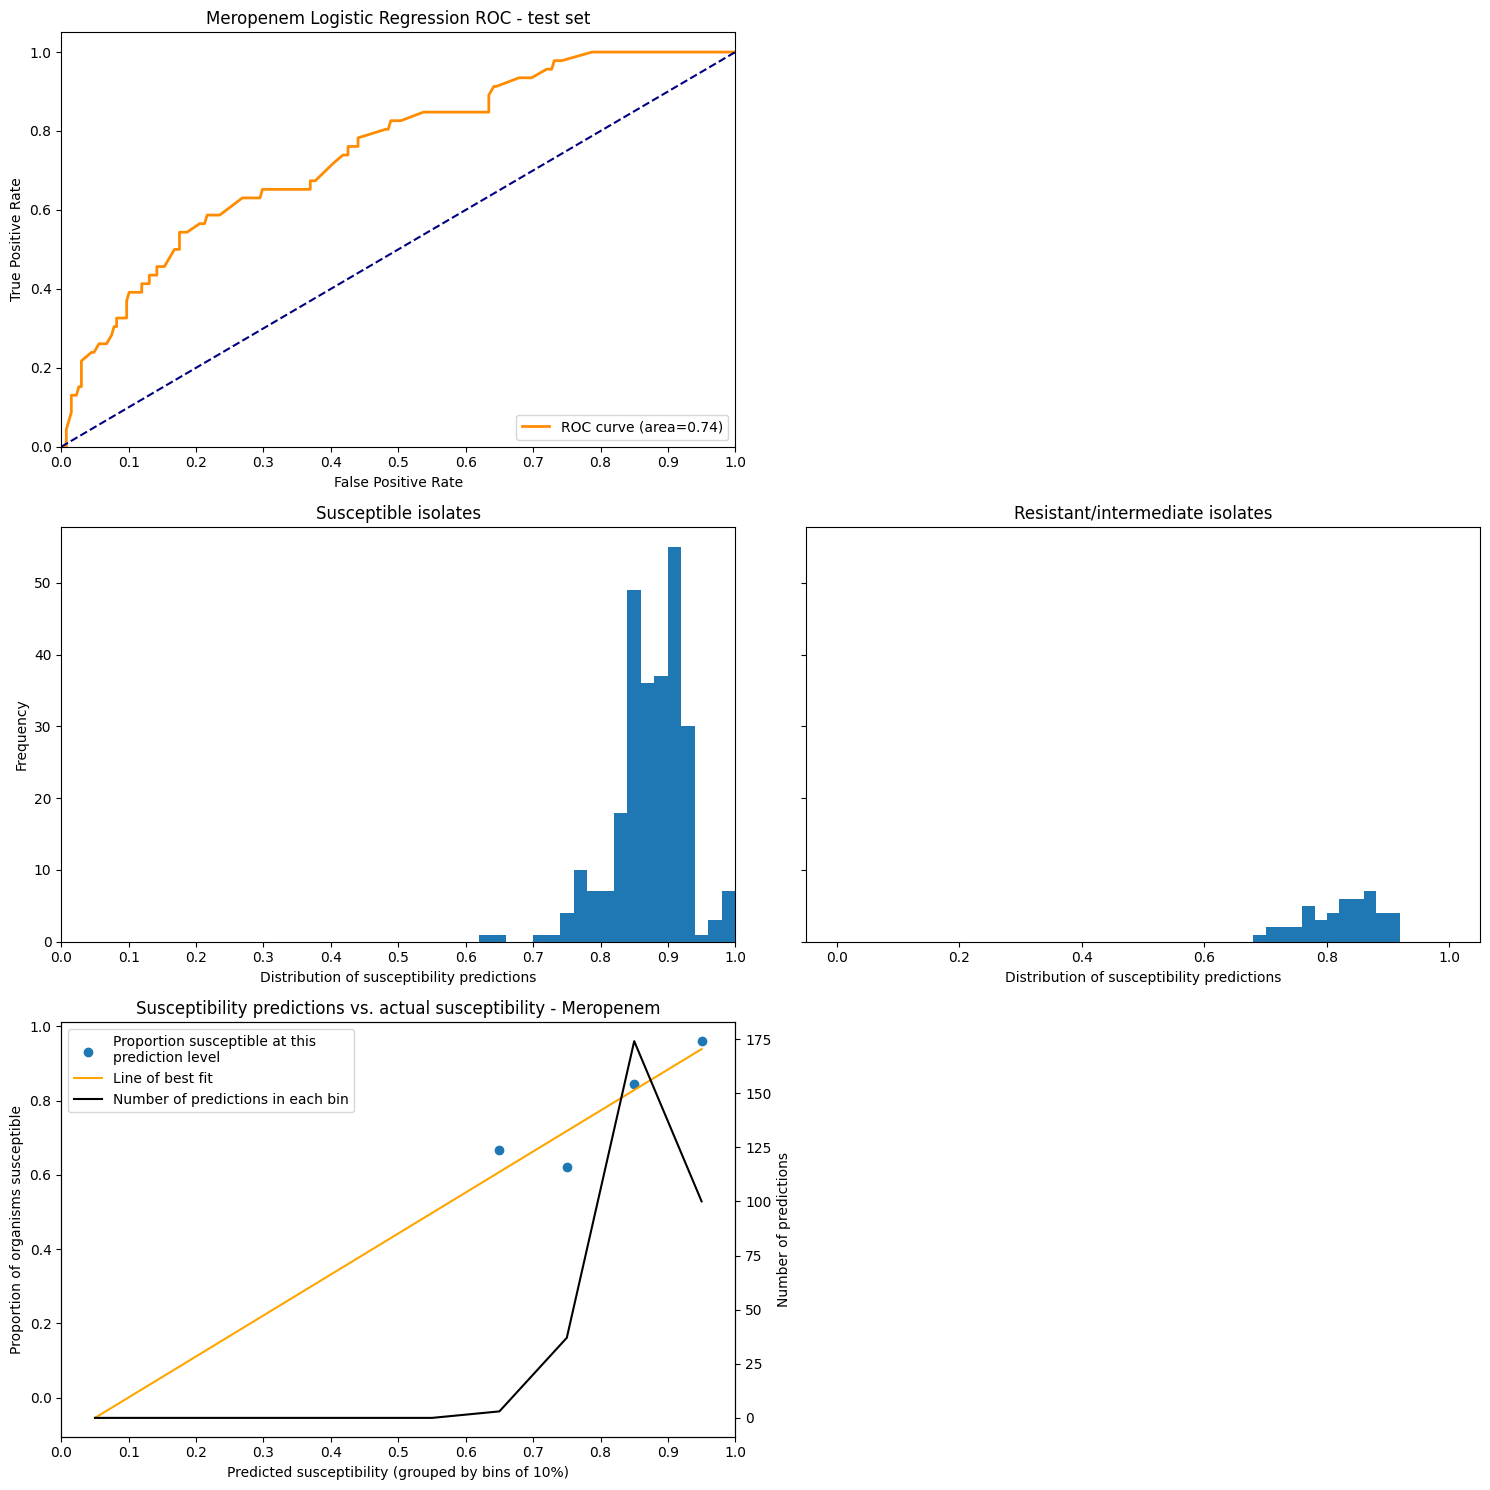


Logistic regression model for Piptaz:

Logistic Regression Coefficients
ClinicalESBL                                1.5790
PiptazResistance_nonsusceptible             1.2474
acquisition_ICU                             0.3604
PriorNonPenicillin                          0.3582
RecentHospitalization                       0.2784
acquisition_ward                            0.1463
Age                                        -0.0071
PriorPenicillin                            -0.0674
sex_M                                      -0.0888
adm_service_surgical                       -0.3322
PiptazResistance_susceptible               -1.1252

Probability of susceptibility: prediction outputs
Susceptible isolates min:     0.34
                     median:  0.84
                     mean:    0.83
                     max:     0.95
                     
Resistant isolates   min:     0.34
                     median:  0.83
                     mean:    0.78
                     max:     0.96
             

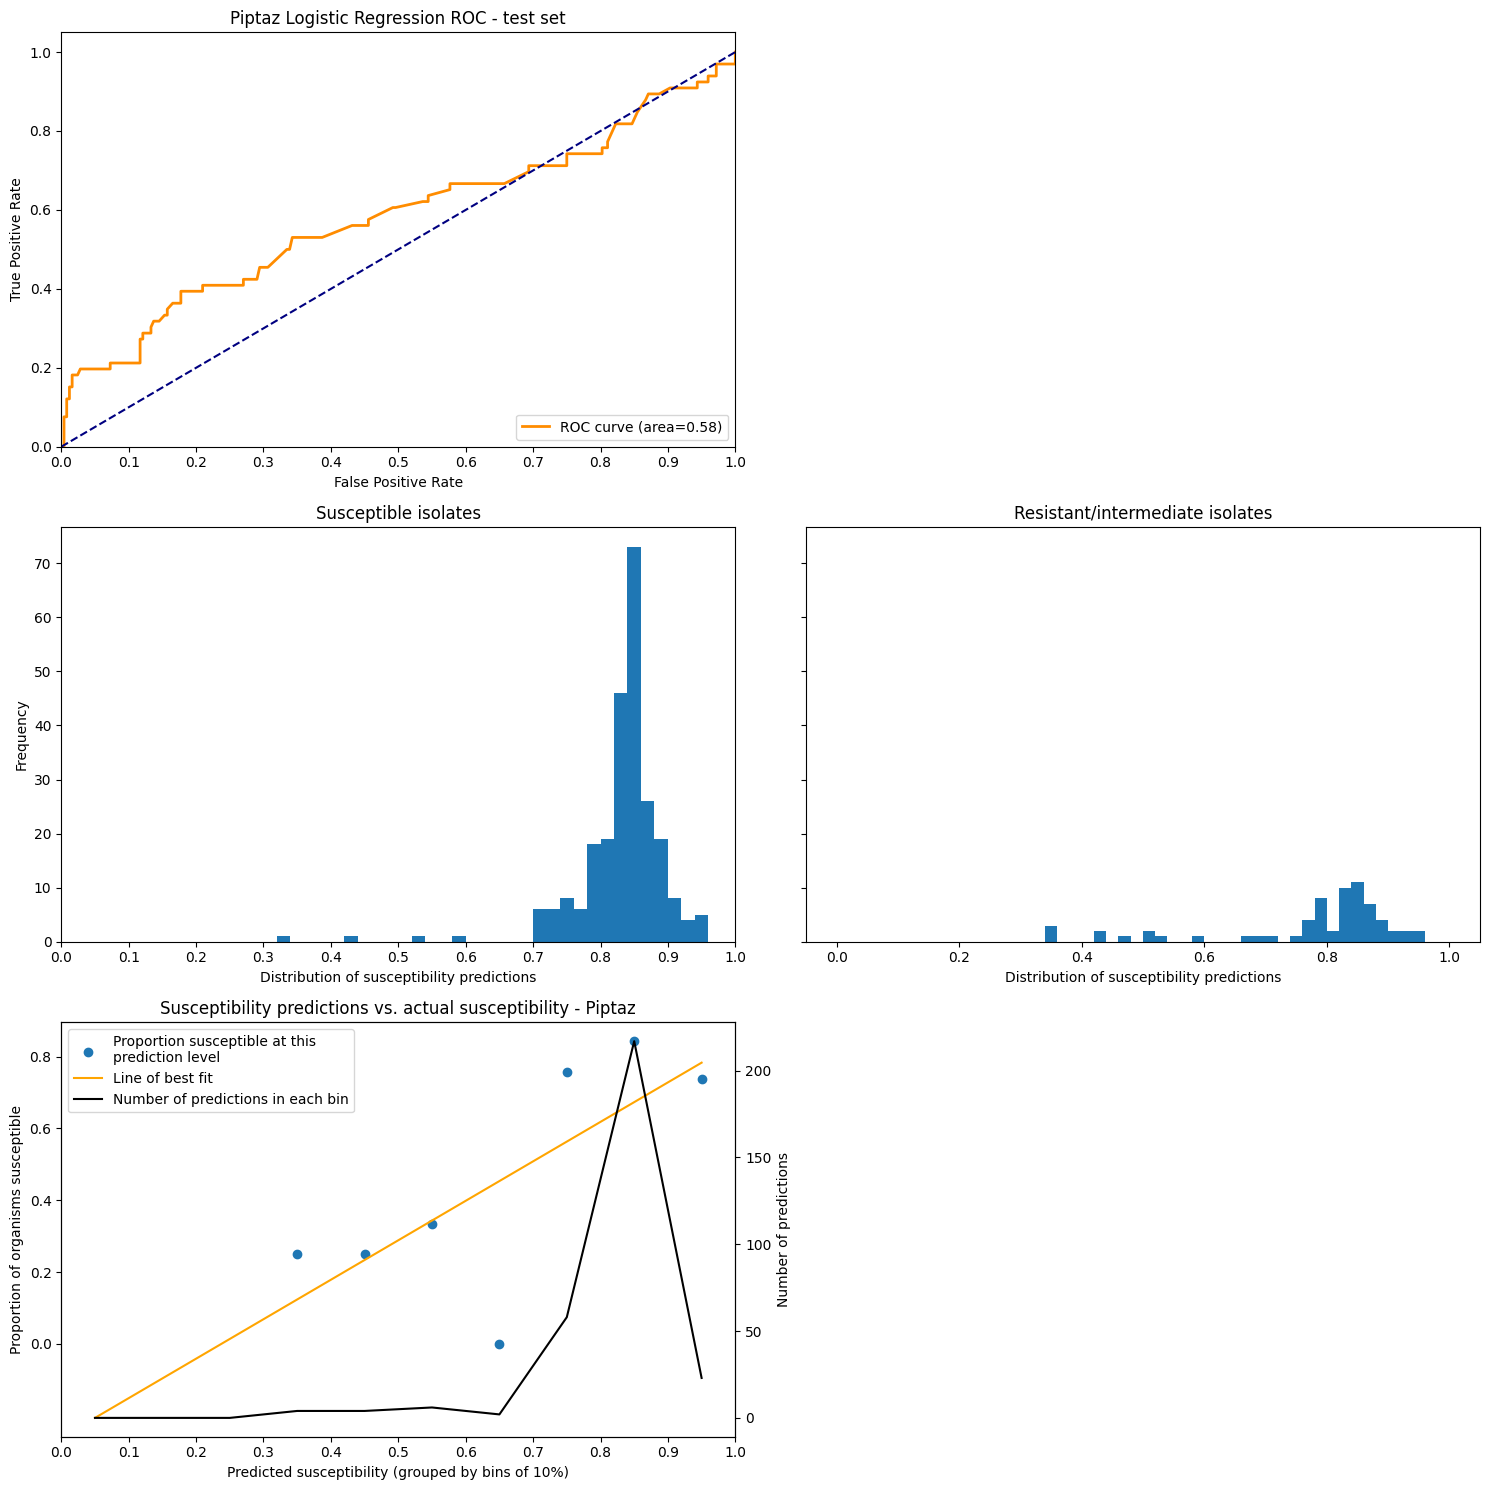


Logistic regression model for Ceftazidime:

Logistic Regression Coefficients
ClinicalESBL                                1.5611
acquisition_ICU                             0.9989
PriorCephalosporin                          0.4108
sex_M                                       0.3524
RecentHospitalization                       0.1922
acquisition_ward                            0.1533
adm_service_surgical                        0.0053
Age                                        -0.0071
PriorNonCephalosporin                      -0.0221
CeftazidimeResistance_nonsusceptible       -0.1815
CeftazidimeResistance_susceptible          -1.0910

Probability of susceptibility: prediction outputs
Susceptible isolates min:     0.28
                     median:  0.75
                     mean:    0.74
                     max:     0.91
                     
Resistant isolates   min:     0.11
                     median:  0.70
                     mean:    0.68
                     max:     0.88
        

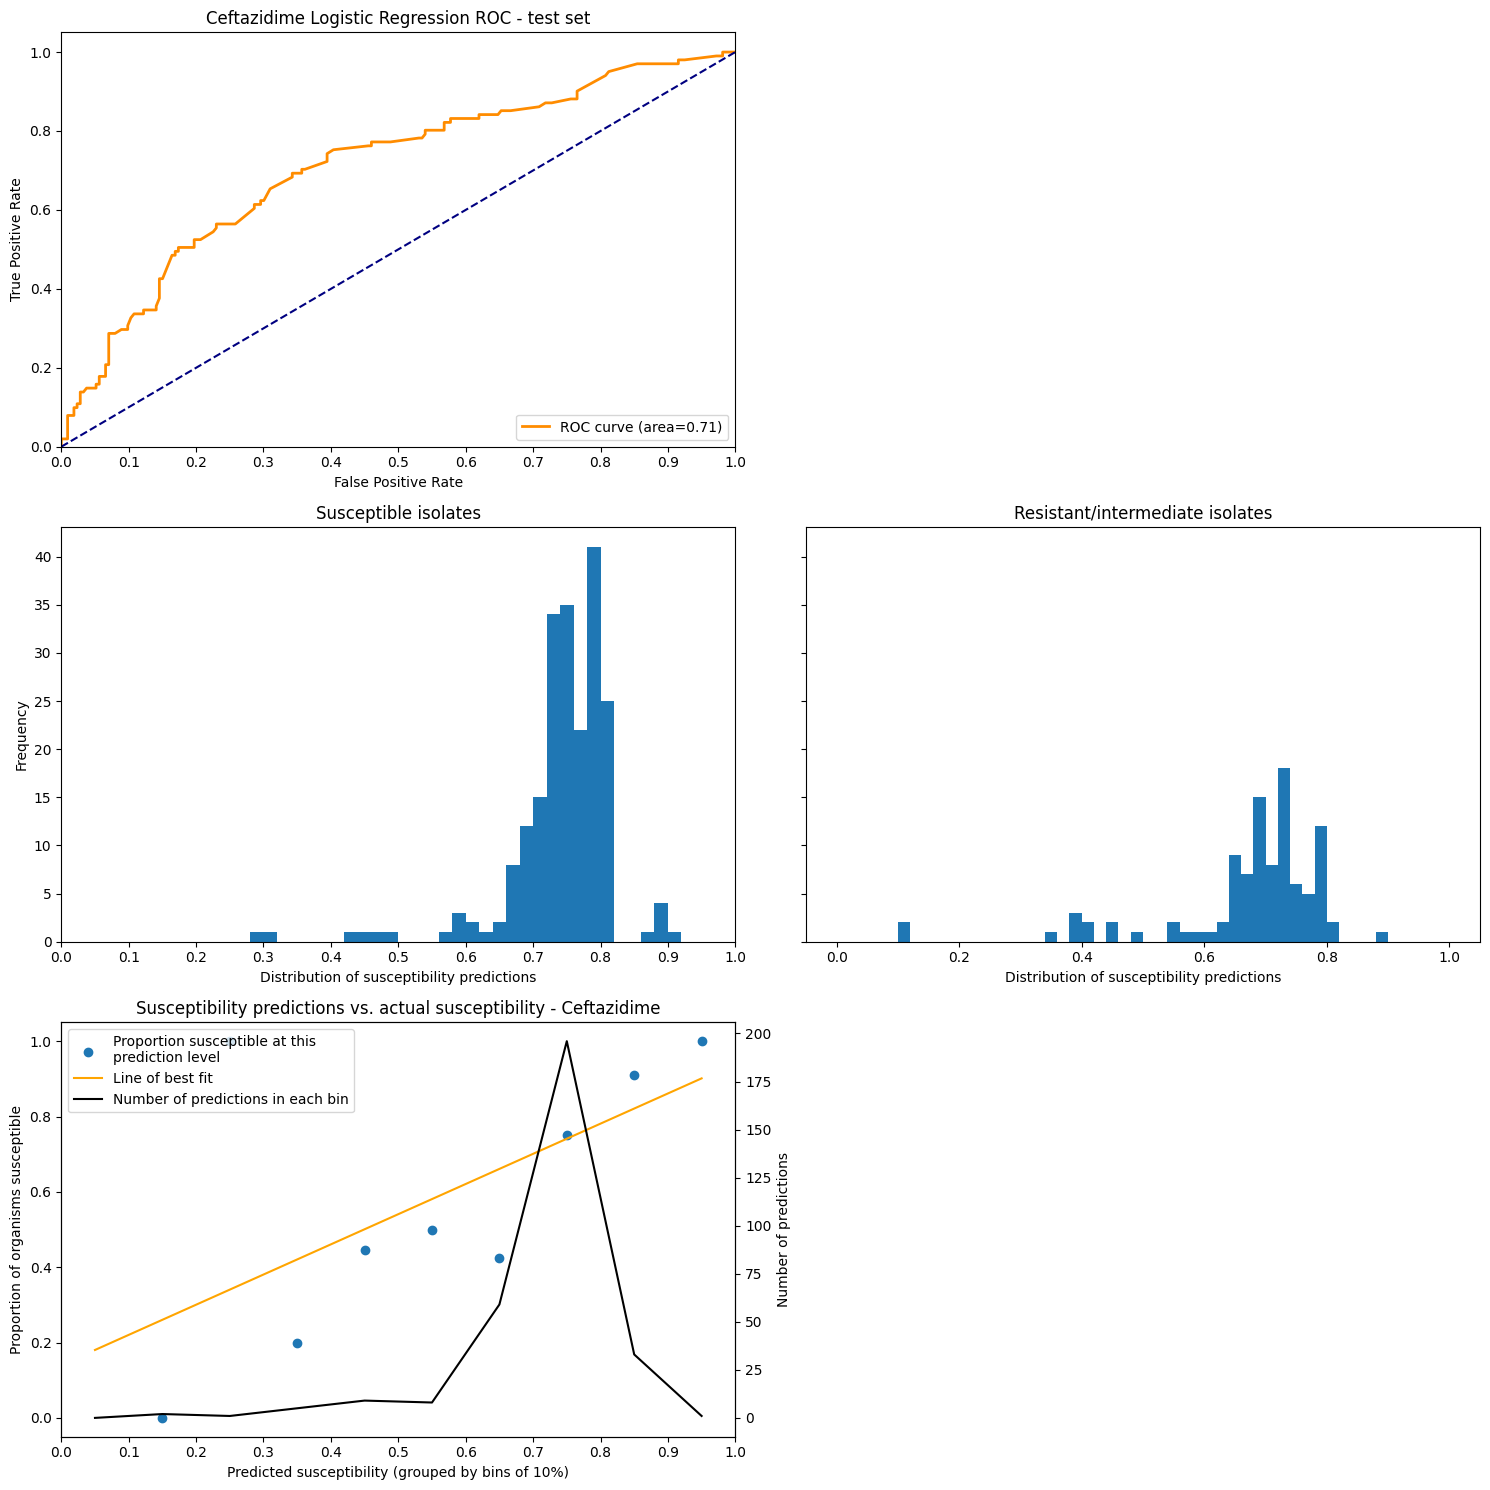


Logistic regression model for Ceftriaxone:

Logistic Regression Coefficients
ClinicalESBL                                1.9199
CeftriaxoneResistance_nonsusceptible        1.6264
acquisition_ICU                             1.1534
sex_M                                       0.5809
PriorCephalosporin                          0.4842
PriorNonCephalosporin                       0.2255
acquisition_ward                            0.2155
RecentHospitalization                       0.1861
Age                                        -0.0114
adm_service_surgical                       -0.2148
CeftriaxoneResistance_susceptible          -0.6328

Probability of susceptibility: prediction outputs
Susceptible isolates min:     0.13
                     median:  0.71
                     mean:    0.69
                     max:     0.87
                     
Resistant isolates   min:     0.05
                     median:  0.65
                     mean:    0.57
                     max:     0.82
        

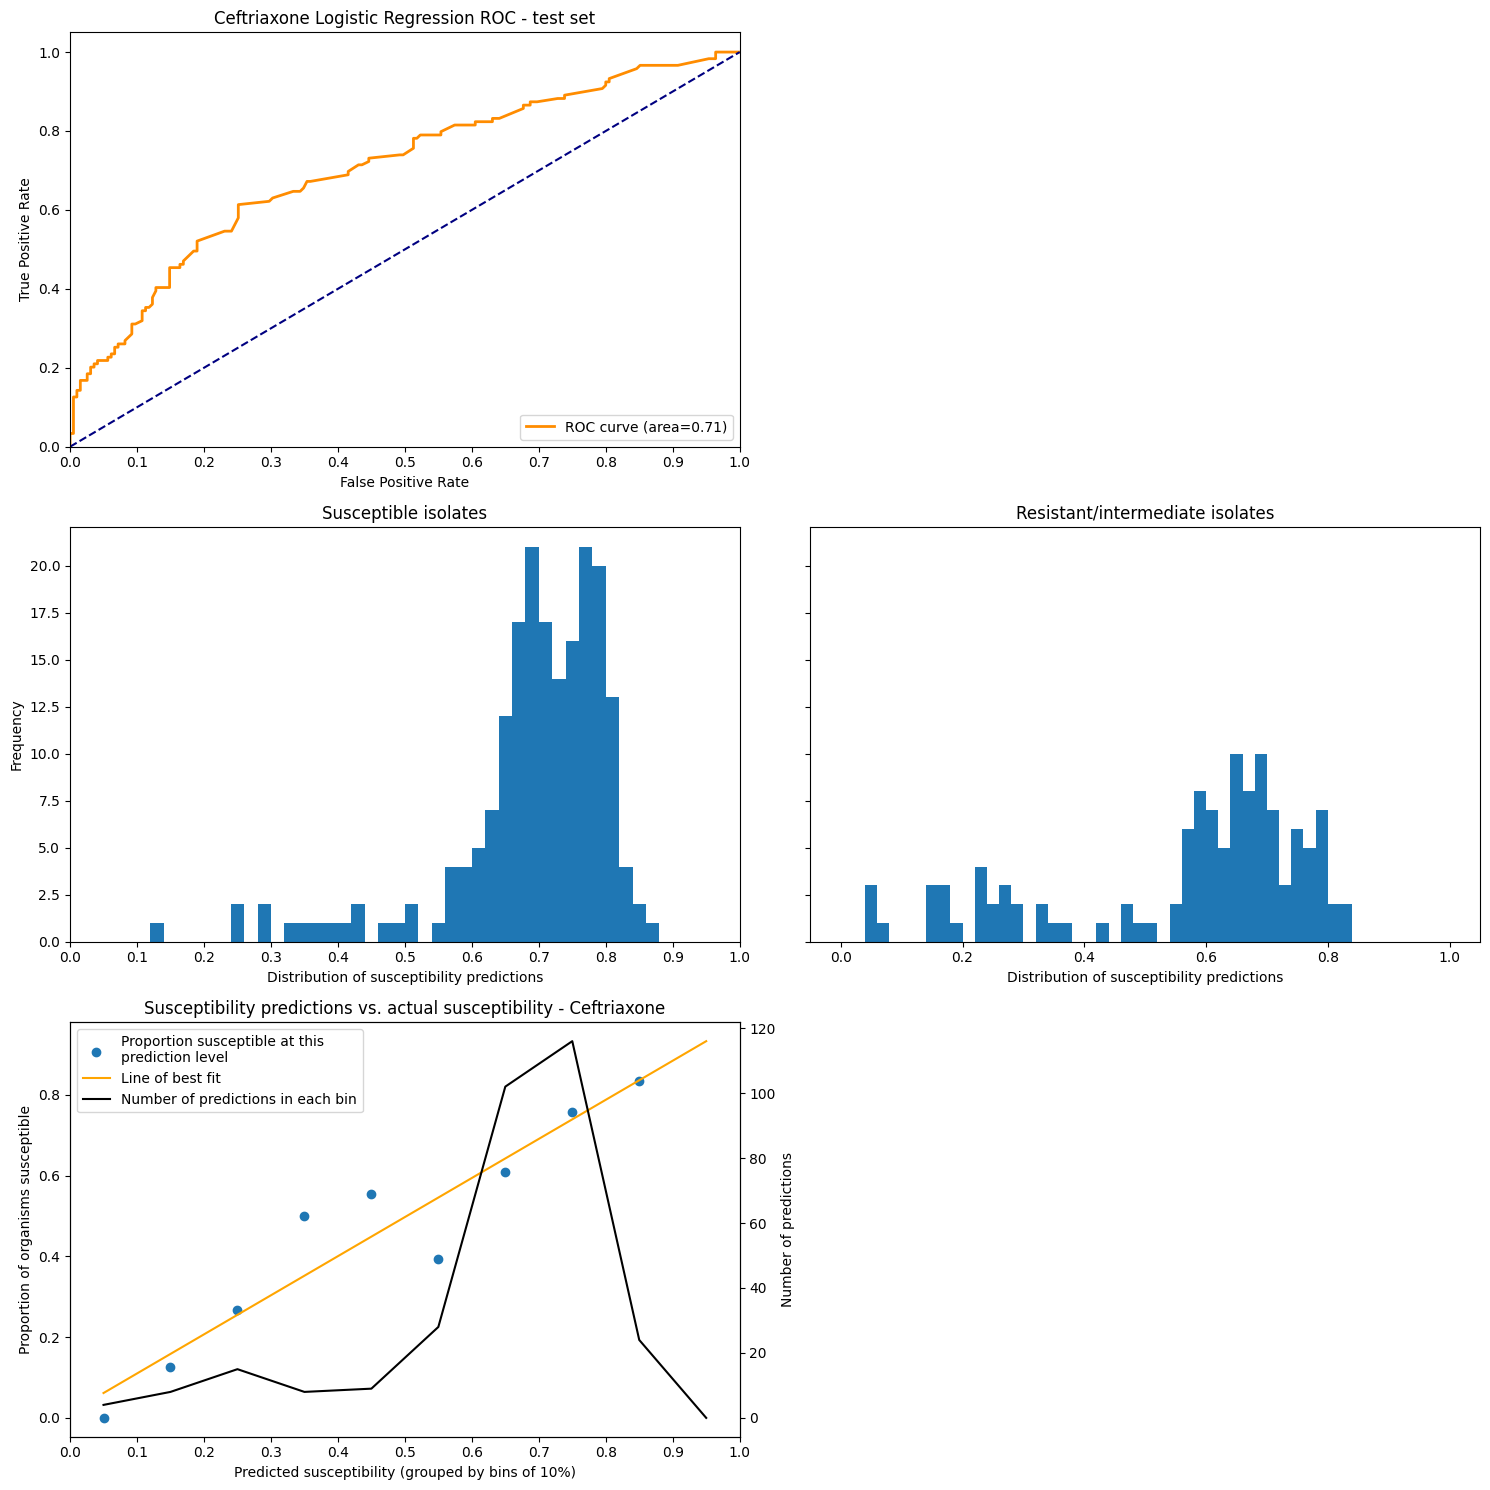


Logistic regression model for Ciprofloxacin:

Logistic Regression Coefficients
CiprofloxacinResistance_nonsusceptible      1.4909
ClinicalESBL                                0.8306
RecentHospitalization                       0.2191
PriorNonFQ                                  0.1723
PriorFQ                                     0.1184
Age                                        -0.0019
adm_service_surgical                       -0.0783
acquisition_ward                           -0.1520
sex_M                                      -0.1529
CiprofloxacinResistance_susceptible        -0.4333
acquisition_ICU                            -0.8894

Probability of susceptibility: prediction outputs
Susceptible isolates min:     0.26
                     median:  0.79
                     mean:    0.79
                     max:     0.91
                     
Resistant isolates   min:     0.19
                     median:  0.78
                     mean:    0.72
                     max:     0.89
      

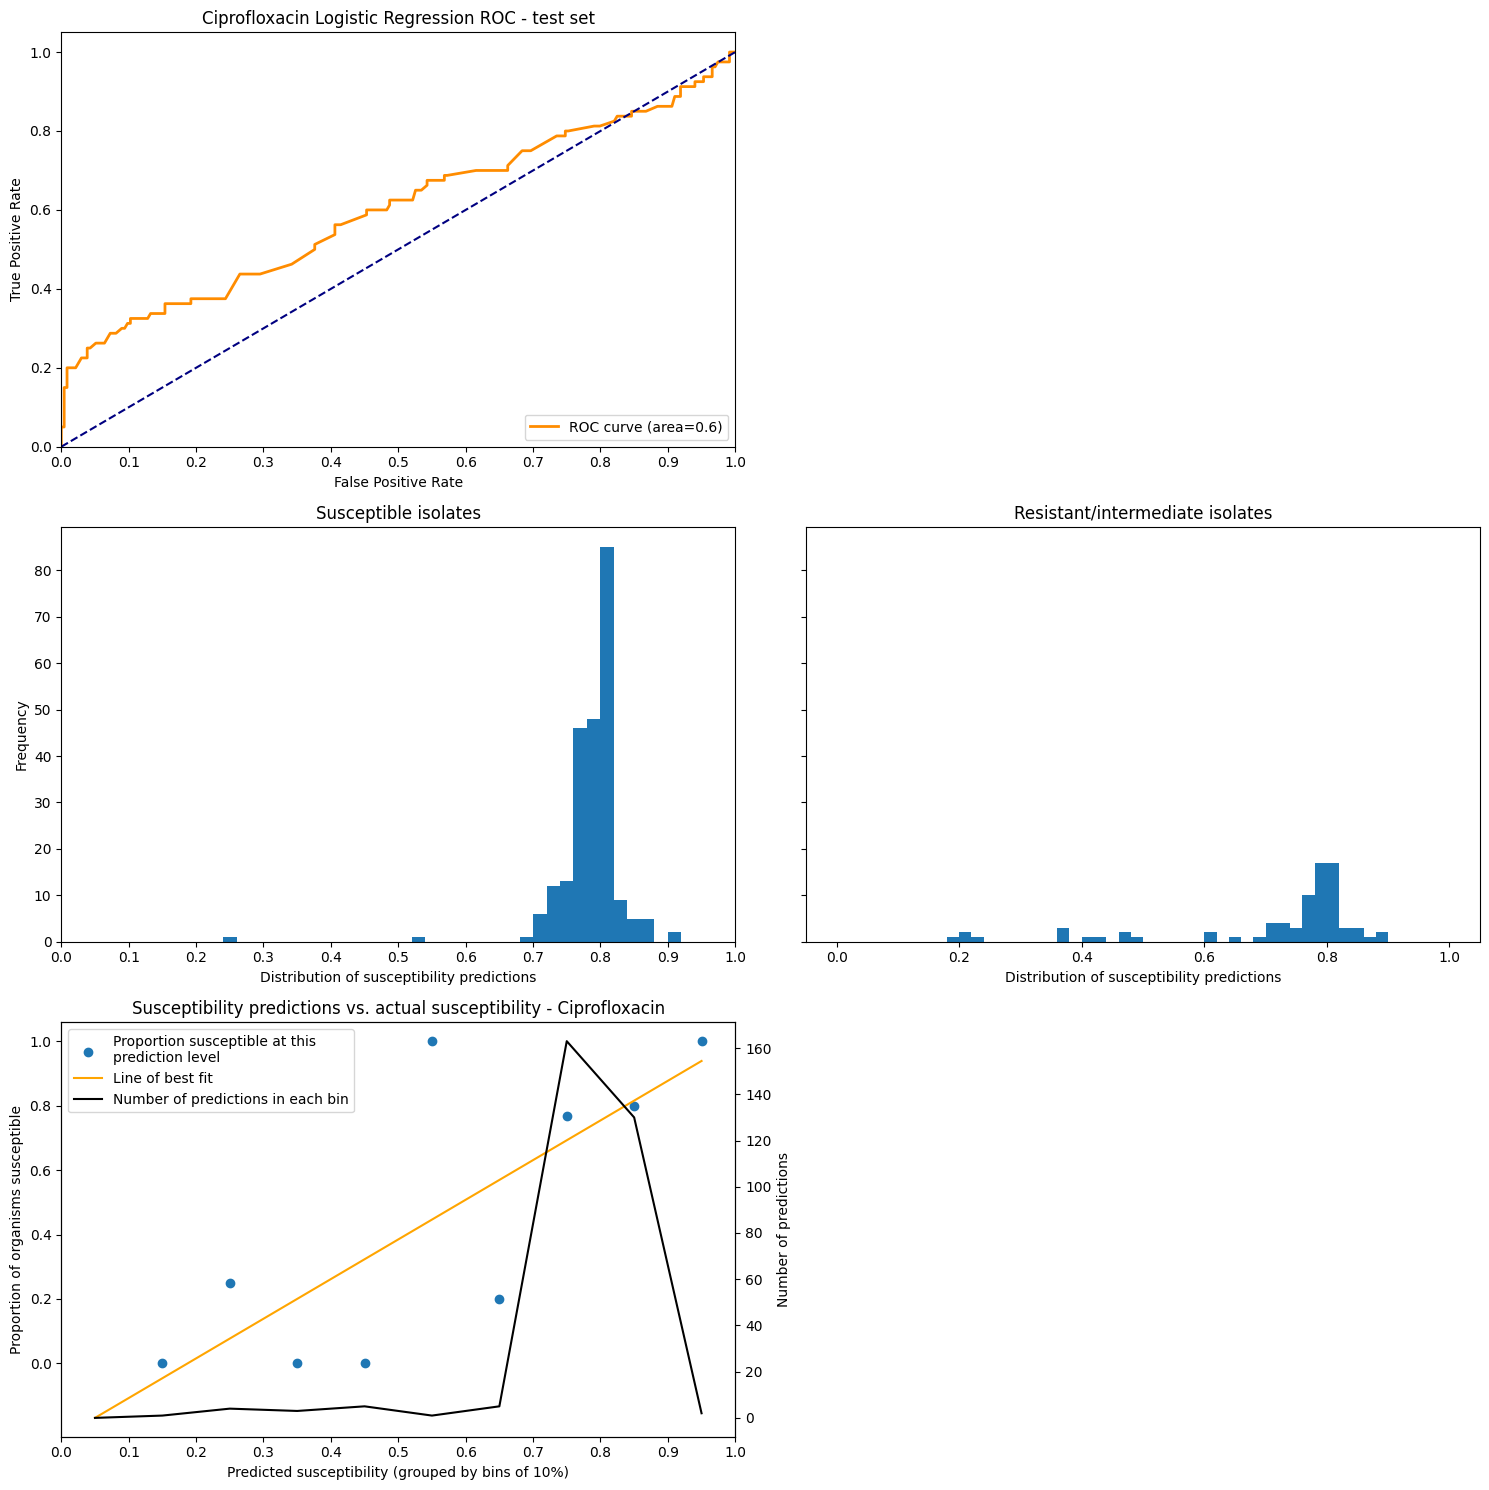

In [18]:
# Divide data into temporal 80-20 train-test sets
train_set, test_set= np.split(one_hot_data, [int(.8 *len(one_hot_data))])

# Collect a list of AUCs of the receiver operating characteristic
AUCROCs = []

for antibiotic in antibiotic_list:
    
    print('\nLogistic regression model for {}:\n'.format(antibiotic))
    
    regression_inputs = ['Age','sex_M',                         
                         'acquisition_ICU','acquisition_ward',
                         'adm_service_surgical','RecentHospitalization',
                         
                         'Prior'+antibiotic_classes[antibiotic],
                         'PriorNon'+antibiotic_classes[antibiotic],
                          antibiotic+'Resistance_susceptible',antibiotic+'Resistance_nonsusceptible',
                         
                         'ClinicalESBL'
                        ]
    
    # 0 = susceptible, 1 = resistant
    X_train = train_set[regression_inputs]
    X_test  = test_set [regression_inputs]
    Y_train = train_set[antibiotic+'_FINAL_imp']
    Y_test  = test_set [antibiotic+'_FINAL_imp']
    
    reg = linear_model.LogisticRegression(max_iter=500,penalty=None)
    reg.fit(X_train,Y_train)
    
    # Coefficients sorted by size
    print('Logistic Regression Coefficients')
    for i in sorted(zip(reg.coef_[0], reg.feature_names_in_),reverse=True):
        print('{:<42} {: .4f}'.format(i[1],i[0]))

    # Zip together prediction values and actual test values
    # Then sort by susceptible strains first, followed by prediction values
    predict_results = sorted((zip(reg.predict_proba(X_test)[:,0],Y_test)),key=lambda x:(x[1],x[0]))

    # Separate out predictions on susceptible and resistant isolates
    susceptible_isolates = []
    resistant_isolates   = []
    for i in predict_results:
        if i[1]==1:
            resistant_isolates.append(i[0])
        else: susceptible_isolates.append(i[0])

    # Print descriptive statistics
    print('\nProbability of susceptibility: prediction outputs')

    print('''Susceptible isolates min: {:> 8.2f}
                     median: {: .2f}
                     mean:   {: .2f}
                     max:    {: .2f}
                     '''.format(min(susceptible_isolates),
                                np.median(susceptible_isolates),
                                np.mean(susceptible_isolates),
                                max(susceptible_isolates)))    
    print('''Resistant isolates   min: {:> 8.2f}
                     median: {: .2f}
                     mean:   {: .2f}
                     max:    {: .2f}
                     '''.format(min(resistant_isolates),
                                np.median(resistant_isolates),
                                np.mean(resistant_isolates),
                                max(resistant_isolates)))  

    print('Mean predicted susceptibility of all isolates: {:.2f}'.format(np.mean(list(i[0] for i in predict_results))))

    
    # Generate plots

    # Calculate and plot ROC based on test set
    fpr, tpr, thresholds = metrics.roc_curve(Y_test,reg.decision_function(X_test))
    AUC = metrics.roc_auc_score(Y_test,reg.decision_function(X_test))

    fig, ax = plt.subplots(nrows=3,ncols=2, 
                           sharex='col',sharey = "row", 
                           figsize=(15,15))

    ax[0,0].plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area={:.2})".format(AUC))

    ax[0,0].plot([0, 1], [0, 1], color="navy", linestyle="--")
    ax[0,0].set_xlim([0.0, 1.0])
    ax[0,0].set_ylim([0.0, 1.05])
    ax[0,0].xaxis.set_tick_params(labelbottom=True)    
    ax[0,0].set_xlabel("False Positive Rate")
    ax[0,0].set_ylabel("True Positive Rate")
    ax[0,0].set_title("{} Logistic Regression ROC - test set".format(antibiotic))
    ax[0,0].legend(loc="lower right")

    # Calculate and plot ROC based on train set
    fpr, tpr, thresholds = metrics.roc_curve(Y_train,reg.decision_function(X_train))
    AUC = metrics.roc_auc_score(Y_train,reg.decision_function(X_train))
    AUCROCs.append(AUC)

    '''
    # Calculate and plot ROC based on train set    
    ax[0,1].plot(fpr, tpr, color="darkorange", lw=2,
        label="ROC curve (area={:.2})".format(AUC))

    ax[0,1].plot([0, 1], [0, 1], color="navy", linestyle="--")
    ax[0,1].set_xlim([0.0, 1.0])
    ax[0,1].set_ylim([0.0, 1.05])
    ax[0,1].set_xticks(np.arange(0,1.1,0.1))
    ax[0,1].xaxis.set_tick_params(labelbottom=True)
    ax[0,1].set_xlabel("False Positive Rate")
    ax[0,1].set_ylabel("True Positive Rate")
    ax[0,1].set_title("{} Logistic Regression ROC - train set".format(antibiotic))
    ax[0,1].legend(loc="lower right")            
    '''
    ax[0,1].axis('off') # Delete this line if we want to see above plot
    
    # Plot a histogram of predictions on susceptible and resistant isolates    
    ax[1,0].hist(susceptible_isolates, bins=50,range=(0,1))    
    ax[1,0].set_title('Susceptible isolates')
    ax[1,0].set_ylabel('Frequency')
    ax[1,0].set_xlabel('Distribution of susceptibility predictions')
    ax[1,0].xaxis.set_tick_params(labelbottom=True)    

    ax[1,1].hist(resistant_isolates, bins=50,range=(0,1))
    ax[1,1].set_title('Resistant/intermediate isolates')
    ax[1,1].set_xlabel('Distribution of susceptibility predictions')
    ax[1,1].xaxis.set_tick_params(labelbottom=True)    

    # Divide the predictions into 10 bins, and count the number of predictions for resistant and susceptible in each bin
    print('\n{:<12}  {}  {}  {}'.format('Bin minimum','S count','R count','S percentage'))

    # First, obtain raw prediction or decision function values to create bins
    probability_list = [x[0] for x in predict_results]

    # Create bins of 0.1 each
    hist_edges = np.arange(0,1.05,0.1)

    # For later plotting
    bin_medians = np.arange(0.05,1.05,0.1)
    bin_susceptibilities = []
    bin_counts = [0]*len(bin_medians)

    # Then, loop over bins
    for i in range(len(hist_edges)-1):

        # Count the number of susceptible and resistant predictions in each bin
        susceptible_number = 0
        resistant_number = 0        
        for j in predict_results:
            if j[0]>=hist_edges[i] and j[0]<hist_edges[i+1]:
                if j[1] == 0: susceptible_number +=1
                if j[1] == 1: resistant_number   +=1
                bin_counts[i] += 1

        # Print and plot observations for each bin
        try:
            percent_susceptible = susceptible_number/(resistant_number+susceptible_number)
            print('{:> 11.2f}{:>10}{:>9}{:>14.2f}'.format(hist_edges[i],
                                                          susceptible_number,
                                                          resistant_number,
                                                          percent_susceptible))            
            bin_susceptibilities.append(percent_susceptible)

        except ZeroDivisionError:
            print('{:> 11.2f}{:>10}{:>9}{:>14}'.format(hist_edges[i],susceptible_number,resistant_number,np.nan))
            bin_susceptibilities.append(np.nan)

    print()

    # Plot a scatterplot of binned probabilities and actual susceptibility rates in each bin
    ax2a = ax[2,0]
    ax2b = ax[2,0].twinx()

    ax2a.set_title('Susceptibility predictions vs. actual susceptibility - {}'.format(antibiotic))
    ax2a.set_xlabel('Predicted susceptibility (grouped by bins of 10%)')
    ax2a.set_xticks(np.arange(0,1.1,0.1))
    ax2a.set_ylabel('Proportion of organisms susceptible')

    # Create a bar chart
    ax2b.plot(bin_medians,bin_counts,color='black',label='Number of predictions in each bin')
    ax2b.set_ylabel('Number of predictions')

    # Create a scatter plot
    bin_susceptibilities = np.array(bin_susceptibilities)
    ax2a.scatter(bin_medians,bin_susceptibilities,color='C0',label='Proportion susceptible at this\nprediction level')
    ax2a.set_yticks(np.arange(0,1.1,0.2))    

    # Create a line of best fit
    non_nan_indices = np.isfinite(bin_medians) & np.isfinite(bin_susceptibilities)
    m,b = np.polyfit(bin_medians[non_nan_indices], bin_susceptibilities[non_nan_indices], 1)
    ax2a.plot(bin_medians,m*bin_medians+b,c='orange',label='Line of best fit')    

    # Create a legend
    lines, labels = ax2a.get_legend_handles_labels()
    lines2, labels2 = ax2b.get_legend_handles_labels()
    ax2a.legend(lines + lines2, labels + labels2, loc='upper left')

    # Delete the bottom right graph and plot the others
    ax[2,1].axis('off')
    fig.patch.set_facecolor('white') # White background for easier copy/pasting
    plt.tight_layout()
    plt.show()

## Writing the regression model (with _all_ data) to file

In [19]:
for antibiotic in antibiotic_list:

    regression_inputs = ['Age','sex_M',
                         
                         'acquisition_ICU','acquisition_ward',
                         'adm_service_surgical',
                         'RecentHospitalization',
                         
                         'Prior'+antibiotic_classes[antibiotic],
                         'PriorNon'+antibiotic_classes[antibiotic],
                          antibiotic+'Resistance_susceptible',antibiotic+'Resistance_nonsusceptible',
                         
                         'ClinicalESBL']

    reg = linear_model.LogisticRegression(max_iter=500,penalty=None)
    reg.fit(one_hot_data[regression_inputs],one_hot_data[antibiotic+'_FINAL_imp'])

    # Print logistic regression coefficients sorted by size
    print('Logistic Regression Coefficients for {}'.format(antibiotic))
    for i in sorted(zip(reg.coef_[0], reg.feature_names_in_),reverse=True):
        print('{:<46} {: .4f}'.format(i[1],i[0]))
    print()
    
    # Save the regression model to pickle
    with open(antibiotic+'_TOH.pickle','wb') as reg_file:
        pickle.dump(reg,reg_file)

Logistic Regression Coefficients for Meropenem
acquisition_ICU                                 1.1558
MeropenemResistance_nonsusceptible              0.8521
sex_M                                           0.5914
RecentHospitalization                           0.5220
acquisition_ward                                0.3401
PriorNonCarbapenem                              0.2280
adm_service_surgical                            0.0845
Age                                            -0.0132
PriorCarbapenem                                -0.6390
MeropenemResistance_susceptible                -0.6630
ClinicalESBL                                   -1.8968

Logistic Regression Coefficients for Piptaz
ClinicalESBL                                    1.7672
PiptazResistance_nonsusceptible                 1.2794
acquisition_ICU                                 0.3563
PriorNonPenicillin                              0.3036
RecentHospitalization                           0.2640
acquisition_ward            

## Quality assurance of the model on previous isolates

In [20]:
QA_data = one_hot_data
for antibiotic in antibiotic_list:
    with open(antibiotic+'_TOH.pickle','rb') as f:
        reg = pickle.load(f)

    regression_inputs = ['Age','sex_M',
                         
                         'acquisition_ICU','acquisition_ward',
                         'adm_service_surgical',
                         'RecentHospitalization',
                         
                         'Prior'+antibiotic_classes[antibiotic],
                         'PriorNon'+antibiotic_classes[antibiotic],
                          antibiotic+'Resistance_susceptible',antibiotic+'Resistance_nonsusceptible',
                         
                         'ClinicalESBL']
    
    regression_values = QA_data[regression_inputs]

    QA_data['Predicted'+antibiotic+'Susceptibility'] = reg.predict_proba(regression_values)[:,0]

# QA_data = data[
#                one_hot_data
#                #(data['Episode']<=7217) & (data['YearOfAdmission']>=2016) # the original data
#               ].join(
#                      QA_data[['Predicted'+antibiotic+'Susceptibility' for antibiotic in antibiotic_list]] # the predicted susceptibilities
#                     )

QA_data.to_excel('2024-05-20 QA data_TOH.xlsx',freeze_panes=(1,0))

### Why does prior hospitalization have negative logsitic regression coefficients?

In [21]:
ICU_priorHosp_coeffs = pd.DataFrame(columns=['ICUExposure','acquisition_ICU','RecentHospitalization'])

for antibiotic in antibiotic_list:
    with open(antibiotic+'_TOH.pickle','rb') as f:
        reg = pickle.load(f)

    regression_inputs = ['Age','sex_M',
                         
                         'acquisition_ICU','acquisition_ward',
                         'adm_service_surgical',
                         'RecentHospitalization','ICUExposure',
                         
                         'Prior'+antibiotic_classes[antibiotic],
                         'PriorNon'+antibiotic_classes[antibiotic],
                          antibiotic+'Resistance_susceptible',antibiotic+'Resistance_nonsusceptible',
                         
                         'ClinicalESBL']
    
    regression_values = one_hot_data[regression_inputs]

    for coefficient in zip(reg.coef_[0], reg.feature_names_in_):
        for regression_input in ['ICUExposure','acquisition_ICU','RecentHospitalization']:
            if coefficient[1]==regression_input:
                ICU_priorHosp_coeffs.loc[antibiotic,regression_input] = coefficient[0]

print('Selected logistic regression coeffcients')
ICU_priorHosp_coeffs

KeyError: "['ICUExposure'] not in index"

In [ ]:
plt.xlabel("RecentHospitalization coefficient")
plt.ylabel("acquisition_ICU coefficient")
# plt.grid(True)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
x=ICU_priorHosp_coeffs['RecentHospitalization']
y=ICU_priorHosp_coeffs['acquisition_ICU']
plt.scatter(x,y)
plt.title("Co-variations of coefficients for RecentHospitalization and acquisition_ICU")
for i, txt in enumerate(ICU_priorHosp_coeffs.index):
    plt.annotate(txt, (x[i], y[i]))
plt.show()